In [1]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import read_lastfm
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, make_scorer
from sklearn.dummy import DummyClassifier

In [2]:
SEED = 42

In [3]:
songs, users = read_lastfm(zip_name="data/lastfm-dataset-1K.zip")
songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                            + songs.track_name.cat.codes

In [5]:
def build_vocab(model):
    emb_vectors = {}
    for n in model.wv.index_to_key:
        emb_vectors[n] = model.wv[n]
    return emb_vectors

def load_model(filename):
    model = Word2Vec.load(filename)
    emb_vectors = build_vocab(model)
    return emb_vectors, model

def train_s2v(df):
    users = df.user_id.unique()
    df = df[df.user_id.isin(users)]
    df = df.sort_values("timestamp")
    df = df[~df.track_name.isna()]
    print(f"Number of entries: {len(df)}")
    assert len(df.query("song_id < 0")) == 0 #Check underflow
    document = df.groupby("user_id").agg(sentences=("song_id", lambda x: list(x) if len(x) else "None"))
    document = document[document.sentences != 'None']
    
    min_count = 1 if document.sentences.apply(len).max() < 5 else 5 #set min count to 1 if no word appears 5 times
    kwargs_122 = {'vector_size': 100, 'window': 3,'negative': 10, 'ns_exponent': 0, 'min_count':1}
    model = Word2Vec(document.sentences.values, **kwargs_122)
    emb_vectors = build_vocab(model)
    print(f"Number of song embeddings: {len(emb_vectors)}")
    return df, emb_vectors, model

def train_tfidf(df):
    
    corpus_df = df.sort_values(["user_id", "timestamp"]).groupby("user_id")\
                .agg(sequence=("song_id", lambda x: list(x) if len(x) else "None"))
    corpus_df = corpus_df[corpus_df.sequence != 'None']
    corpus = corpus_df.values[:,0]
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
    X = vectorizer.fit_transform(corpus)
    song_ids = list(vectorizer.vocabulary_.keys())
    indices = list(vectorizer.vocabulary_.values())
    song_ids = [x for _,x in sorted(zip(indices,song_ids))]
    return pd.DataFrame(data=X.T.todense(), index=song_ids)

In [6]:
def compute_metrics(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc, f1

def predict_RF(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state=SEED, n_estimators=1100, criterion='gini', max_depth=None)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return compute_metrics(y_test, y_pred)

def predict_random(X_train, y_train, X_test, y_test):
    random = DummyClassifier(strategy='uniform', random_state=SEED)
    random.fit(X_train, y_train)
    y_pred = random.predict(X_test)
    return compute_metrics(y_test, y_pred)

def predict_majority(X_train, y_train, X_test, y_test):
    majority = DummyClassifier(strategy='most_frequent', random_state=SEED)
    majority.fit(X_train, y_train)
    y_pred = majority.predict(X_test)
    return compute_metrics(y_test, y_pred)

In [7]:
def create_vectors_pairs(vectors, song_pairs):
    vector_pairs = vectors.merge(song_pairs, right_on="song1", left_index=True)\
            .merge(vectors, left_on="song2", right_index=True)\
            .drop(['song1', 'song2'], axis=1)
    assert len(vector_pairs) == len(song_pairs)
    assert vector_pairs.shape[1] == vectors.shape[1] * 2
    return vector_pairs

In [39]:
def pick_songs_from_same_artist(discography, half_n):
    """Simply chooses random songs pair them with the previous or following one"""
    artist_with_multiple_songs = discography.groupby("artist_name")\
                                .agg(count=("track_name", "count")).reset_index()
    discography = discography.merge(artist_with_multiple_songs)
    
    song_pairs = discography.groupby("artist_name").agg(song1=("song_id", "first"), 
                                                        song2=("song_id", "last"))
    X = song_pairs.sample(half_n, random_state=SEED).values
    y = np.ones(half_n)
    return X, y
    
def pick_songs_from_diff_artist(discography, half_n):
    discography = discography.drop_duplicates("artist_name")
#     half_n = len(discography) // 2
    random_songs = discography.sample(2 * half_n, replace=True, random_state=SEED).song_id.values
    songs1 = random_songs[:half_n]
    songs2 = random_songs[half_n:]
    X = np.c_[songs1, songs2]
    y = np.zeros(half_n)
    return X, y

def create_artist_dataset(discography, n=20000):
    """Create a dataset of song pairs that either appeared in the same context or not""" 
    X_pos, y_pos = pick_songs_from_same_artist(discography, n//2)
    X_neg, y_neg = pick_songs_from_diff_artist(discography, n//2)
    old_X = np.r_[X_pos, X_neg]
    old_y = np.r_[y_pos, y_neg]
    dataset = list(zip(old_X, old_y))
    np.random.seed(SEED)
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    return pd.DataFrame(X, columns=["song1", "song2"]), np.array(y)

In [36]:
def train_dataset(df,discography):
    sample, emb_vectors, model = train_s2v(df)
    s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())
    
    song_pairs, labels = create_artist_dataset(discography, n= min(len(discography), 10000))
    #Only keep song with s2v embeddings
    song_pairs = song_pairs.copy()
    song_pairs['labels'] = labels
    song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
    labels = song_pairs.labels
    song_pairs.drop('labels', axis=1, inplace=True)
    
    tfidf_df = train_tfidf(df)
    tfidf_pairs = create_vectors_pairs(tfidf_df, song_pairs)
    X_train, X_test, y_train, y_test = \
                train_test_split(tfidf_pairs, labels, train_size=0.8, random_state=SEED)
    tfidf_acc, tfidf_f1 = predict_RF(X_train, X_test, y_train, y_test)
    
    
    s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)
    X_train, X_test, y_train, y_test = \
                train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
    s2v_acc, s2v_f1 = predict_RF(X_train, X_test, y_train, y_test)
    return tfidf_acc, tfidf_f1, s2v_acc, s2v_f1

In [37]:
def train_all_dataset(sizes = [1e3, 1e4, 1e5, 1e6, 1e7, "all"]):
    tfidf_accs, tfidf_f1s, s2v_accs, s2v_f1s = [],[],[],[]
    for size in sizes:
        print(f"Starting training on dataset of size {size}")
        if size == "all":
            df = songs.copy()
        else:
            df = songs.sample(int(size))
        discography = df[["artist_name", "track_name", "song_id"]].drop_duplicates()
        tfidf_acc, tfidf_f1, s2v_acc, s2v_f1 = train_dataset(df, discography)
        print(f"For {size}:", tfidf_acc, tfidf_f1, s2v_acc, s2v_f1)
        tfidf_accs.append(tfidf_acc)
        tfidf_f1s.append(tfidf_f1)
        s2v_accs.append(s2v_acc)
        s2v_f1s.append(s2v_f1)
    return tfidf_accs, tfidf_f1s, s2v_accs, s2v_f1s

In [40]:
sizes = [1e3, 1e4, 1e5, 1e6, 1e7, "all"]
tfidf_accs, tfidf_f1s, s2v_accs, s2v_f1s = train_all_dataset(sizes = sizes)

Starting training on dataset of size 1000.0
Number of entries: 1000
Number of song embeddings: 996


/Users/julien/Documents/Cours/MLDB/mlbd/mlbd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/julien/Documents/Cours/MLDB/mlbd/mlbd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


For 1000.0: 1.0 0.0 1.0 0.0
Starting training on dataset of size 10000.0
Number of entries: 10000
Number of song embeddings: 9516
For 10000.0: 0.9744114636642784 0.0 0.9744114636642784 0.0
Starting training on dataset of size 100000.0
Number of entries: 99999
Number of song embeddings: 72938
For 100000.0: 0.8772401433691757 0.06802721088435373 0.8915770609318996 0.0
Starting training on dataset of size 1000000.0
Number of entries: 999997
Number of song embeddings: 372026
For 1000000.0: 0.6671597633136095 0.16974169741697417 0.7366863905325444 0.0
Starting training on dataset of size 10000000.0
Number of entries: 9999994
Number of song embeddings: 1175860
For 10000000.0: 0.5092491838955386 0.4348370927318296 0.5375408052230686 0.2272727272727273
Starting training on dataset of size all
Number of entries: 19098850
Number of song embeddings: 1498723
For all: 0.504 0.4974670719351571 0.5005 0.503232222774739


In [ ]:
def plot_metrics(sizes, tfidf_accs, tfidf_f1s, s2v_accs, s2v_f1s):
    def plot_metric(tfidf, s2v, metric, sizes, ax):
        n = len(tfidf)
        ax.plot(sizes, tfidf, label="TF-IDF")
        ax.plot(sizes, s2v, label="Song2Vec")
        ax.set_ylabel(metric)
        ax.set_xlabel("Number of songs in the dataset")
        ax.set_title("Performance comparison wrt the dataset size")
        ax.legend()
        
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    plot_metric(tfidf_accs, s2v_accs, "Accuracy", sizes, axes[0])
    plot_metric(tfidf_f1s, s2v_f1s, "F1 score", sizes, axes[1])
    plt.show()

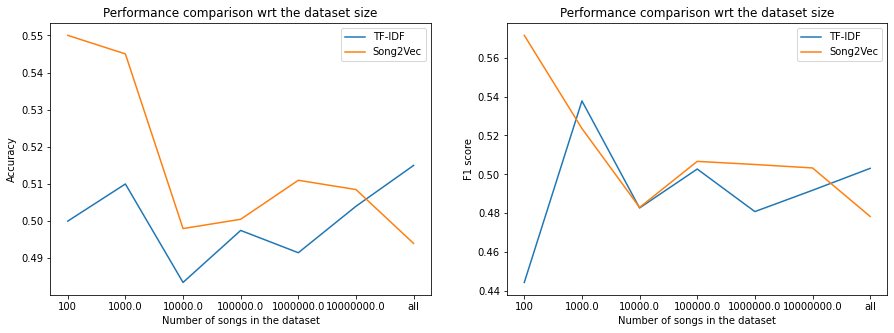

In [123]:
plot_metrics(sizes, tfidf_accs, tfidf_f1s, s2v_accs, s2v_f1s)